# Dynamic prediction of TTA : $(X_{t-1}, X_t) \mapsto TTA_t$

First attempt to dynamic prediction which is direct regression of TTA but with the integration a temporal component.

In [1]:
%matplotlib qt
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy
import seaborn as sns
from skimage import measure # to get contours from masks
import sklearn

import napari

sns.set_theme()

C:\ProgramData\Anaconda3\lib\site-packages\napari\_qt\__init__.py:37: UserWarning: 
    napari was tested with QT library `>=5.12.3`.
    The version installed is 5.9.7. Please report any issues with this
    specific QT version at https://github.com/Napari/napari/issues.
    
  warn(message=warn_message)


## Loading Data

In [3]:
os.chdir("D:/Hugo/Anaphase/")
data = pd.read_csv("Analysis_BF_f0001-1-100.1.csv", sep=";", comment="#", index_col="idx")
data = data[data["time_to_anaphase"] >= 0]

print(data.shape)
data.head()

(495, 16)


,frame,time,mom_x,mom_y,daugh_x,daugh_y,mom_surf,daugh_surf,relat_surf,anaphase,anaphase_int,time_to_anaphase,cum_relat_surf,delta_mom_surf,delta_daugh_surf,delta_relat_surf
idx,,,,,,,,,,,,,,,,
0,0,0,463.509804,225.369863,-1.000000,-1.000000,229.730504,0.000000,0.000000,False,0,36,0.000000,-2.000015,9.534260,0.041866
0,1,6,463.481911,225.084507,460.542099,238.588235,227.730488,9.534260,0.041866,False,0,30,0.020842,2.000015,26.872597,0.116610
0,2,12,460.345420,225.602740,456.110886,239.965517,229.730504,36.406857,0.158476,False,0,24,0.066853,-5.000000,15.147087,0.070927
0,3,18,460.578297,225.698630,455.691877,240.914286,224.730504,51.553944,0.229403,False,0,18,0.106912,3.715675,17.147087,0.071328
0,4,24,461.524165,225.985915,456.054041,241.146341,228.446179,68.701031,0.300732,False,0,12,0.145739,-2.000000,13.147057,0.060714


In [4]:
# prepare the training set
from sklearn.model_selection import train_test_split

relat_surf_lag1 = []
for idx in data.index.unique():
    traj = data.loc[idx]
    
    for i, time in enumerate(traj["time"]):
        if time == 0:
            relat_surf_lag1.append(0)
        else:
            relat_surf_lag1.append(traj.iloc[i-1]["relat_surf"])
data["relat_surf_lag1"] = relat_surf_lag1

features = ["relat_surf", "relat_surf_lag1"]

data = data[(data["relat_surf"] != 0) & (data["relat_surf_lag1"] != 0)]

X_train, X_test, y_train, y_test = train_test_split(data[features].values, data["time_to_anaphase"].values, train_size=0.8)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(287, 2) (72, 2) (287,) (72,)


In [5]:
fig, ax = plt.subplots(1, 1)
ax.plot(data["relat_surf_lag1"], data["relat_surf"], ".")
ax.set_xlabel("relat_surf(t-1)")
ax.set_ylabel("relat_surf(t)")
plt.show()

## Fitting and prediction

- Linear regression : R^2 = 0.77 and MSE on test set is 5.4 minutes.

### Training

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor

lm = LinearRegression().fit(X_train, y_train)

print(f"R^2 coefficient : {round(lm.score(X_train, y_train), 2)}")

R^2 coefficient : 0.63


In [7]:
%matplotlib qt
predictions_on_train_set = lm.predict(X_train)

plot = True
if plot:
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(X_train[:, 0], X_train[:, 1], y_train, c="b")
    ax.scatter(X_train[:, 0], X_train[:, 1], predictions_on_train_set, marker="+", c="r")
    
    ax.set_xlabel(features[0])
    ax.set_ylabel(features[1])
    ax.set_zlabel('TTA (min)')
    ax.set_title("Data distribution")

In [8]:
if type(lm) == LinearRegression:
    print(f"Regression equation : {lm.coef_[0]} * {features[0]} + {lm.coef_[1]} * {features[1]} + {lm.intercept_}")
elif type(lm) in [RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor]:
    print(f"Features importance: {lm.feature_importances_}.")

Regression equation : -28.604987313470183 * relat_surf + -34.570407826616815 * relat_surf_lag1 + 32.91855953522585


### Evaluation

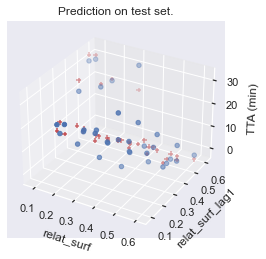

In [21]:
predictions_on_test_set = lm.predict(X_test)

plot = True
if plot:
    %matplotlib qt
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(X_test[:, 0], X_test[:, 1], y_test, c="b")
    ax.scatter(X_test[:, 0], X_test[:, 1], predictions_on_test_set, marker="+", c="r")
    
    ax.set_xlabel(features[0])
    ax.set_ylabel(features[1])
    ax.set_zlabel('TTA (min)')
    ax.set_title("Prediction on test set.")

Mean squared error on test set: 3.843411536874284


Text(0.5, 1.0, 'L2 loss given the sign of (y_true - y_pred)')

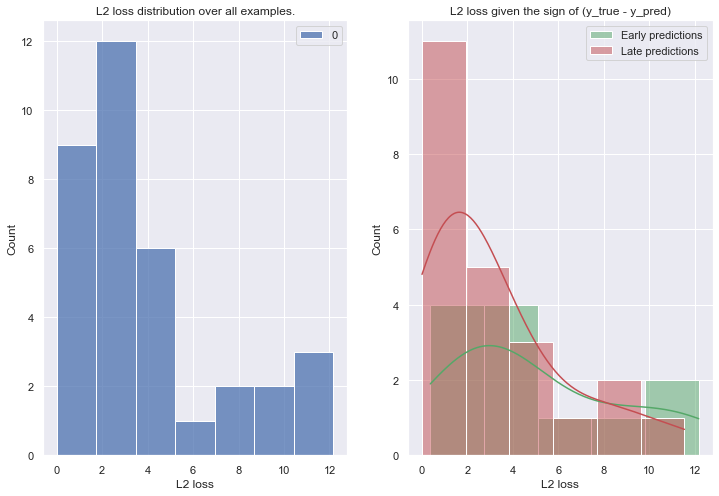

In [20]:
%matplotlib inline
# evaluation with the clasical RMSE
losses, signed_losses = [], []
for obs, pred, gt in zip(X_test, predictions_on_test_set, y_test):
    loss = np.sqrt((pred - gt) ** 2)
    signed_losses.append(gt - pred)
    losses.append(loss)
losses = np.array(losses) 
signed_losses = np.array(signed_losses)

print(f"Mean squared error on test set: {losses.mean()}")

fig, axes = plt.subplots(1, 2, figsize=(12, 8))

# RMSE distribution
sns.histplot(losses, ax=axes[0])
axes[0].set_title("L2 loss distribution over all examples.")
axes[0].set_xlabel("L2 loss")

# Conditional distributions given the sign of the error
sns.histplot(losses[signed_losses >= 0], color="g", kde=True, label="Early predictions", ax=axes[1])
sns.histplot(losses[signed_losses < 0], color="r", kde=True, label="Late predictions", ax=axes[1])
axes[1].legend()
axes[1].set_xlabel("L2 loss")
axes[1].set_title("L2 loss given the sign of (y_true - y_pred)")

### K-fold cross validation

In [9]:
from sklearn.model_selection import KFold

features = ["relat_surf", "relat_surf_lag1"]

X, y = data[features].values, data["time_to_anaphase"].values.reshape(-1, 1)
n_iter = 10
kf = KFold(n_splits=n_iter)

rmse, scores = [], []
for train_idx, test_idx in kf.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    lm = LinearRegression().fit(X_train, y_train)
    scores.append(lm.score(X_test, y_test))
    rmse.append(np.sqrt(((y_test - lm.predict(X_test)) ** 2).mean()))
rmse = np.array(rmse)
scores = np.array(scores)

print(f"R^2 on {n_iter} folds : {scores}")
print(f"Mean R^2 on {n_iter}-fold cross-validation : {round(scores.mean(), 2)} +- {round(scores.std(), 2)}.\n")

print(f"RMSE on {n_iter} folds : {scores}")
print(f"Mean RMSE on {n_iter}-fold cross-validation : {round(rmse.mean(), 2)}  +- {round(rmse.std(), 2)} min.")

R^2 on 10 folds : [0.70296891 0.54825373 0.60727248 0.73040406 0.57323622 0.28216923
 0.63919192 0.78763176 0.73708044 0.68743902]
Mean R^2 on 10-fold cross-validation : 0.63 +- 0.14.

RMSE on 10 folds : [0.70296891 0.54825373 0.60727248 0.73040406 0.57323622 0.28216923
 0.63919192 0.78763176 0.73708044 0.68743902]
Mean RMSE on 10-fold cross-validation : 6.28  +- 1.5 min.
